<a href="https://colab.research.google.com/github/zmunilla/TFM/blob/main/6_Triplet_Loss_PEC4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CONECTAR CON GOOGLE DRIVE**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**CARGAR LIBRERÍAS**

In [ ]:
import os
import random
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
from torchvision.models import resnet50, ResNet50_Weights

In [ ]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

**FUNCIÓN DE REDIMENSIONAR SIN DEFORMAR**

In [ ]:
from torchvision.transforms import functional as TF

class ResizeWithPadding:
    def __init__(self, size, fill=0):
        self.size = size  # (alto, ancho)
        self.fill = fill

    def __call__(self, img):
        w, h = img.size
        target_h, target_w = self.size
        scale = min(target_w / w, target_h / h)
        new_w, new_h = int(w * scale), int(h * scale)

        img = TF.resize(img, (new_h, new_w))

        pad_left = (target_w - new_w) // 2
        pad_top = (target_h - new_h) // 2
        pad_right = target_w - new_w - pad_left
        pad_bottom = target_h - new_h - pad_top

        img = TF.pad(img, [pad_left, pad_top, pad_right, pad_bottom], fill=self.fill)
        return img

**CONFIGURAR PARAMETROS Y TRANSFORMACIONES**

In [ ]:
#TRANSFORMACIÓN REFORZADA

train_dir = '/content/drive/MyDrive/TFM/CAT_REDEF_20/left/train'
val_dir = '/content/drive/MyDrive/TFM/CAT_REDEF_20/left/val'
batch_size = 32
num_epochs = 12
embedding_dim = 512  # Tamaño del embedding
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


resize_with_padding = ResizeWithPadding((224, 224))  # Dimensiones para ResNet18

#Aumentación de datos

train_transform = transforms.Compose([
    resize_with_padding,
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.2, 0.8))], p=0.3),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, shear=5),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.4),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
    ])

#Transformación sin aumentación de datos

val_transform = transforms.Compose([
    resize_with_padding,
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
    ])

transform= val_transform

**FUNCION CREACION TRIPLETES**

In [ ]:
class TripletDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # Cargar solo clases con al menos 2 imágenes para poder hacer tripletes

        self.classes = [cls for cls in os.listdir(root_dir)
                        if len(os.listdir(os.path.join(root_dir, cls))) >= 2]

        self.class_to_images = {
            cls: os.listdir(os.path.join(root_dir, cls))
            for cls in self.classes
        }

        self.image_list = [(cls, img) for cls in self.classes
                           for img in self.class_to_images[cls]]

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        # Ancla
        anchor_class, anchor_img = self.image_list[idx]
        positive_class = anchor_class

        # Imagen positiva distinta al ancla
        positive_img = random.choice([
            img for img in self.class_to_images[positive_class]
            if img != anchor_img
        ])

        # Negativa de otra clase
        negative_class = random.choice([cls for cls in self.classes if cls != anchor_class])
        negative_img = random.choice(self.class_to_images[negative_class])

        # Cargar imágenes
        anchor_path = os.path.join(self.root_dir, anchor_class, anchor_img)
        positive_path = os.path.join(self.root_dir, positive_class, positive_img)
        negative_path = os.path.join(self.root_dir, negative_class, negative_img)

        anchor = Image.open(anchor_path).convert('RGB')
        positive = Image.open(positive_path).convert('RGB')
        negative = Image.open(negative_path).convert('RGB')

        if self.transform:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)

        return anchor, positive, negative #devuelve el triplete


**MODELO BASE - DATASETS - DATALOADERS**

In [ ]:
# USANDO RESNET18 Y DIMENSIÓN DE EMBEDDING 512

from torchvision.models import resnet18, ResNet18_Weights

class EmbeddingNet(nn.Module):
    def __init__(self, embedding_dim=512, normalize=True): #normalización para usar distancia coseno
        super(EmbeddingNet, self).__init__()
        self.normalize = normalize
        self.backbone = resnet18(weights=ResNet18_Weights.DEFAULT) #pesos entrenados de ResNet18

        num_ftrs = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(num_ftrs, embedding_dim)

    def forward(self, x):
        x = self.backbone(x)
        if self.normalize:
            x = F.normalize(x, p=2, dim=1)
        return x

# DATASETS Y DATALOADERS

train_dataset = TripletDataset(train_dir, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TripletDataset(val_dir, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

**FUNCIÓN DE PÉRDIDA TRIPLET LOSS**

In [ ]:
#COSENO FUNCTION TRIPLET LOSS

class CosineTripletLoss(nn.Module):
    def __init__(self, margin=0.3):
        super().__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        cos_pos = F.cosine_similarity(anchor, positive)
        cos_neg = F.cosine_similarity(anchor, negative)
        loss = F.relu(cos_neg - cos_pos + self.margin)
        return loss.mean()


**ENTRENAMIENTO MODELO**

In [ ]:

import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, recall_score
import matplotlib.pyplot as plt
import pandas as pd

loss_fn = CosineTripletLoss(margin=0.3) #Función de pérdida con margin=0.3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_with_metrics(model, loader, loss_fn):
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    distances = []
    labels = []  # 1 para positivos, 0 para negativos
    predictions = []  # predicción binaria: dist_pos < dist_neg

    with torch.no_grad():
        for anchor, positive, negative in loader:
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

            anchor_emb = model(anchor)
            positive_emb = model(positive)
            negative_emb = model(negative)

            dist_pos = 1 - F.cosine_similarity(anchor_emb, positive_emb)
            dist_neg = 1 - F.cosine_similarity(anchor_emb, negative_emb)

            loss = loss_fn(anchor_emb, positive_emb, negative_emb)
            val_loss += loss.item()

            correct += (dist_pos < dist_neg).sum().item()
            total += anchor.size(0)

            # Usamos esto para métricas binarizadas
            distances.extend(dist_pos.cpu().tolist())
            labels.extend([1] * len(dist_pos))
            predictions.extend((dist_pos < dist_neg).cpu().int().tolist())

            distances.extend(dist_neg.cpu().tolist())
            labels.extend([0] * len(dist_neg))
            predictions.extend((dist_neg < dist_pos).cpu().int().tolist())

            del anchor, positive, negative, anchor_emb, positive_emb, negative_emb, dist_pos, dist_neg

    accuracy = correct / total
    avg_val_loss = val_loss / len(loader)
    auc = roc_auc_score(labels, [-d for d in distances])
    recall = recall_score(labels, predictions)

    return accuracy, avg_val_loss, auc, recall

# Entrenamiento
model = EmbeddingNet(embedding_dim=512, normalize=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) #Optimizador Adama con TA=0.0001

train_losses, val_losses = [], []
val_accuracies, val_aucs, val_recalls = [], [], []

best_auc = 0.0
best_epoch = 0
num_epochs = 12

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for anchor, positive, negative in train_loader:
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

        optimizer.zero_grad()
        anchor_emb = model(anchor)
        positive_emb = model(positive)
        negative_emb = model(negative)

        loss = loss_fn(anchor_emb, positive_emb, negative_emb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        del anchor, positive, negative, anchor_emb, positive_emb, negative_emb

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    val_acc, val_loss, val_auc, val_recall = evaluate_with_metrics(model, val_loader, triplet_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_aucs.append(val_auc)
    val_recalls.append(val_recall)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"  Val Accuracy: {val_acc:.4f} | AUC: {val_auc:.4f} | Recall: {val_recall:.4f}")

    if val_auc > best_auc:
        best_auc = val_auc
        best_epoch = epoch
        best_model_state = model.state_dict()
        best_optimizer_state = optimizer.state_dict()
        print("  Nuevo mejor modelo guardado")
    else:
        print("  No mejora en AUC.")

# Guardar el mejor modelo en base al valor de AUC
save_path = "/content/drive/MyDrive/TFM/modelos2/best_triplet_model_right_aucR18_512_final_cos.pth"
torch.save({
    'epoch': best_epoch,
    'model_state_dict': best_model_state,
    'optimizer_state_dict': best_optimizer_state,
    'best_auc': best_auc
}, save_path)

print(f"\n Modelo guardado en {save_path} con mejor AUC de {best_auc:.4f} en la epoch {best_epoch+1}")


Epoch 1/12
  Train Loss: 0.2446 | Val Loss: 0.8860
  Val Accuracy: 0.6429 | AUC: 0.6522 | Recall: 0.6429
  ✅ Nuevo mejor modelo guardado
Epoch 2/12
  Train Loss: 0.1479 | Val Loss: 0.8877
  Val Accuracy: 0.7143 | AUC: 0.6547 | Recall: 0.7143
  ✅ Nuevo mejor modelo guardado
Epoch 3/12
  Train Loss: 0.1251 | Val Loss: 0.8442
  Val Accuracy: 0.6857 | AUC: 0.6802 | Recall: 0.6857
  ✅ Nuevo mejor modelo guardado
Epoch 4/12
  Train Loss: 0.1128 | Val Loss: 0.8186
  Val Accuracy: 0.6571 | AUC: 0.6957 | Recall: 0.6571
  ✅ Nuevo mejor modelo guardado
Epoch 5/12
  Train Loss: 0.0779 | Val Loss: 0.8341
  Val Accuracy: 0.7286 | AUC: 0.6688 | Recall: 0.7286
  No mejora en AUC.
Epoch 6/12
  Train Loss: 0.0672 | Val Loss: 0.8804
  Val Accuracy: 0.7000 | AUC: 0.6222 | Recall: 0.7000
  No mejora en AUC.
Epoch 7/12
  Train Loss: 0.0664 | Val Loss: 0.8119
  Val Accuracy: 0.7286 | AUC: 0.7214 | Recall: 0.7286
  ✅ Nuevo mejor modelo guardado
Epoch 8/12
  Train Loss: 0.0544 | Val Loss: 0.8905
  Val Accuracy

**ALMACENAMIENTO DE MÉTRICAS POR ÉPOCA**

In [ ]:
import pandas as pd

# Crear DataFrame con las métricas
metrics_df = pd.DataFrame({
    'Epoch': list(range(1, num_epochs + 1)),
    'Train Loss': train_losses,
    'Val Loss': val_losses,
    'Val Accuracy': val_accuracies,
    'Val AUC': val_aucs,
    'Val Recall': val_recalls
})

# Redondear a 3 decimales
metrics_df = metrics_df.round(4)

# Mostrar primeras filas
print(metrics_df.head())

# Guardar como CSV
metrics_df.to_csv('/content/drive/MyDrive/TFM/metricas/metrics_triplet_training_right512_12_aucR18_final_cos.csv', index=False)


   Epoch  Train Loss  Val Loss  Val Accuracy  Val AUC  Val Recall
0      1      0.2446    0.8860        0.6429   0.6522      0.6429
1      2      0.1479    0.8877        0.7143   0.6547      0.7143
2      3      0.1251    0.8442        0.6857   0.6802      0.6857
3      4      0.1128    0.8186        0.6571   0.6957      0.6571
4      5      0.0779    0.8341        0.7286   0.6688      0.7286


**VISUALIZAR GRÁFICAS A PARTIR DE CSV**

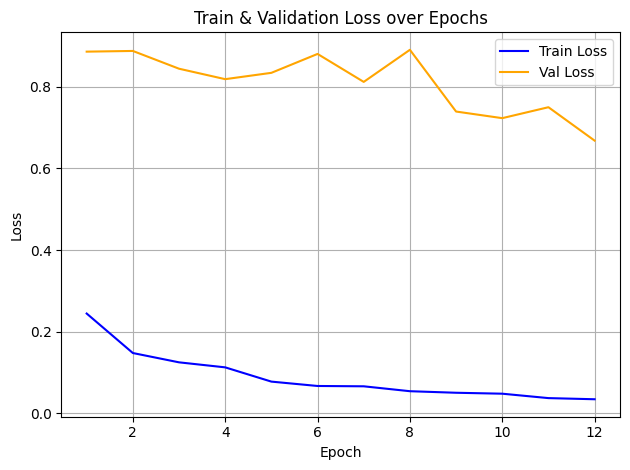

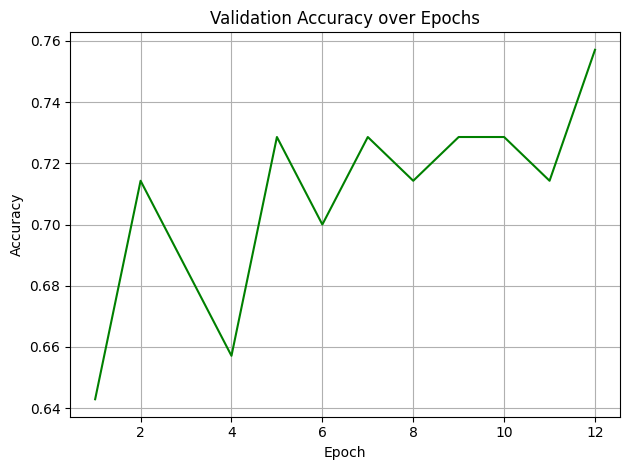

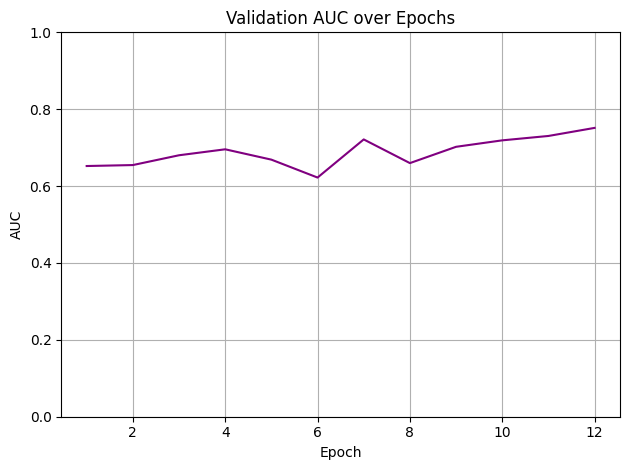

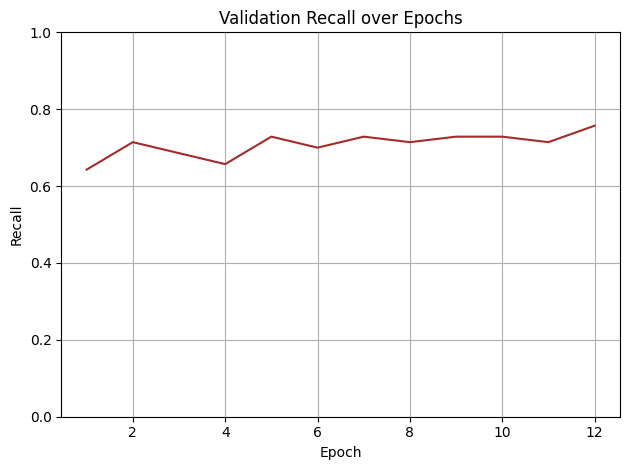

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el CSV con métricas del modelo triplete

csv_path = '/content/drive/MyDrive/TFM/metricas/metrics_triplet_training_right512_12_aucR18_final_cos.csv'
metrics_df = pd.read_csv(csv_path)

# TRAIN Y VAL LOSS
plt.figure()
plt.plot(metrics_df['Epoch'], metrics_df['Train Loss'], label='Train Loss', color='blue')
plt.plot(metrics_df['Epoch'], metrics_df['Val Loss'], label='Val Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train & Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# VAL ACCURACY
plt.figure()
plt.plot(metrics_df['Epoch'], metrics_df['Val Accuracy'], label='Val Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.grid(True)
plt.tight_layout()
plt.show()

# AUC
plt.figure()
plt.plot(metrics_df['Epoch'], metrics_df['Val AUC'], label='Validation AUC', color='purple')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Validation AUC over Epochs')
plt.ylim(0.0, 1.0)
plt.grid(True)
plt.tight_layout()
plt.show()

# RECALL
plt.figure()
plt.plot(metrics_df['Epoch'], metrics_df['Val Recall'], label='Validation Recall', color='brown')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Validation Recall over Epochs')
plt.ylim(0.0, 1.0)
plt.grid(True)
plt.tight_layout()
plt.show()


**CARGAR MODELO**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#RIGHT

model = EmbeddingNet(embedding_dim=512, normalize=True).to(device)
checkpoint_path = "/content/drive/MyDrive/TFM/modelos2/best_triplet_right_R18_512_pesos.pth"
model = load_model_weights(model, checkpoint_path, device)


#LEFT

'''
model = EmbeddingNet(embedding_dim=512, normalize=True).to(device)
checkpoint_path = "/content/drive/MyDrive/TFM/modelos2/best_triplet_left_R18_512_pesos.pth"
model = load_model_weights(model, checkpoint_path, device)
'''


✅ Pesos cargados directamente del state_dict.


'\n#LEFT\n\nmodel = EmbeddingNet(embedding_dim=512, normalize=True).to(device)\ncheckpoint_path = "/content/drive/MyDrive/TFM/modelos2/best_triplet_left_R18_512_pesos.pth"\nmodel = load_model_weights(model, checkpoint_path, device)\n'

**VISUALIZAR CURVA ROC-AUC**

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch.nn.functional as F

def compute_roc_curve(model, dataloader, device, metric='cosine'):
    model.eval()
    scores = []
    labels = []

    with torch.no_grad():
        for anchor, positive, negative in dataloader:
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)

            anchor_emb = model(anchor)
            pos_emb = model(positive)
            neg_emb = model(negative)

            if metric == 'cosine':
                sim_pos = F.cosine_similarity(anchor_emb, pos_emb, dim=1).cpu().numpy()
                sim_neg = F.cosine_similarity(anchor_emb, neg_emb, dim=1).cpu().numpy()
                scores.extend(sim_pos)
                scores.extend(sim_neg)
                labels.extend([1] * len(sim_pos) + [0] * len(sim_neg))
            elif metric == 'euclidean':
                dist_pos = F.pairwise_distance(anchor_emb, pos_emb).cpu().numpy()
                dist_neg = F.pairwise_distance(anchor_emb, neg_emb).cpu().numpy()
                # Convertir distancias a "similaridad inversa" para curva ROC
                scores.extend(-dist_pos)
                scores.extend(-dist_neg)
                labels.extend([1] * len(dist_pos) + [0] * len(dist_neg))
            else:
                raise ValueError("Solo se admite 'cosine' o 'euclidean'")

    # Calcular curva ROC
    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)

    # Graficar curva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    return roc_auc


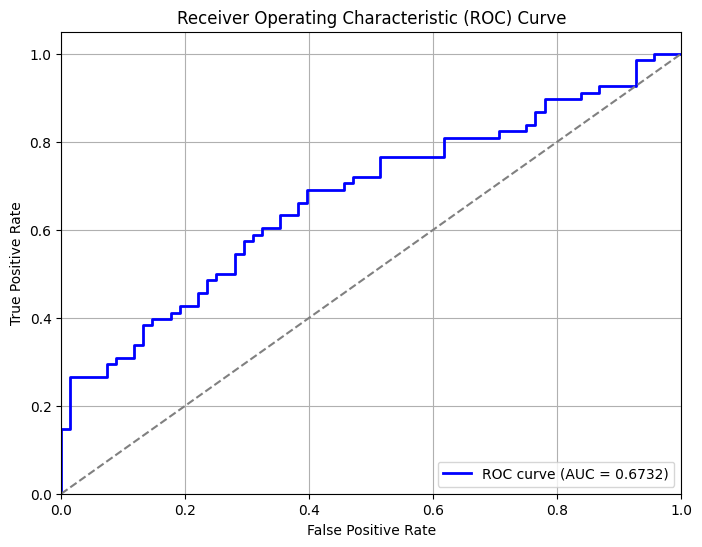

AUC: 0.6732


In [ ]:
roc_auc = compute_roc_curve(model, val_loader, device, metric='cosine')
print(f"AUC: {roc_auc:.4f}")


**CREACIÓN EMBEDDINGS PROMEDIO CON TODAS LAS IMAGENES DISPONIBLES**

In [ ]:
#USAR ESTO

import torch
import os
import pickle
from PIL import Image
from torchvision import transforms
import torch.nn.functional as F

def create_catalog_with_avg_embeddings_pkl(model, catalog_folder, transform, device, output_pkl_path):
    model.eval()
    catalog = {}  # Diccionario final

    for individual in os.listdir(catalog_folder):
        individual_path = os.path.join(catalog_folder, individual)
        if not os.path.isdir(individual_path):
            continue

        images = [f for f in os.listdir(individual_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if not images:
            continue

        embeddings = []
        rep_image_path = os.path.join(individual_path, images[0])  # Ruta de imagen representativa

        for img_name in images:
            img_path = os.path.join(individual_path, img_name)

            # Cargar imagen
            img = Image.open(img_path).convert('RGB')
            img_tensor = transform(img).unsqueeze(0).to(device)

            # Obtener embedding
            with torch.no_grad():
                embedding = model(img_tensor).squeeze(0).cpu()
                embeddings.append(embedding)

        # Calcular promedio de embeddings
        if embeddings:
            avg_embedding = torch.stack(embeddings).mean(dim=0)
            avg_embedding = F.normalize(avg_embedding, p=2, dim=0)

            catalog[individual] = {
                'embedding': avg_embedding,
                'image_path': rep_image_path  # ← solo la ruta representativa
            }

            print(f"Clase {individual}: embedding creado con imagen {rep_image_path}.")

    # Guardar catálogo completo como .pkl
    with open(output_pkl_path, 'wb') as f:
        pickle.dump(catalog, f)

    print(f"\n✅ Catálogo guardado en: {output_pkl_path}")


In [ ]:
#USO DE FUNCIÓN DE CREACIÓN DE EMBEDDINGS PROMEDIO

catalog_folder = "/content/drive/MyDrive/TFM/EMB_APP_1/right"  # Carpeta con carpetas por individuo
output_pkl_path = "/content/drive/MyDrive/TFM/modelos2/catalog_triplet_right_REDEF2.pkl"

create_catalog_with_avg_embeddings_pkl(
    model=model,
    catalog_folder=catalog_folder,
    transform=transform,
    device=device,
    output_pkl_path=output_pkl_path
)


Clase OO_GIB_014: embedding creado con imagen /content/drive/MyDrive/TFM/EMB_APP_1/right/OO_GIB_014/014_img156.jpg.
Clase OO_GIB_005: embedding creado con imagen /content/drive/MyDrive/TFM/EMB_APP_1/right/OO_GIB_005/005_img003.jpg.
Clase OO_GIB_008: embedding creado con imagen /content/drive/MyDrive/TFM/EMB_APP_1/right/OO_GIB_008/008_img093.jpg.
Clase OO_GIB_004: embedding creado con imagen /content/drive/MyDrive/TFM/EMB_APP_1/right/OO_GIB_004/004_img039.jpg.
Clase OO_GIB_002: embedding creado con imagen /content/drive/MyDrive/TFM/EMB_APP_1/right/OO_GIB_002/002_img006.jpg.
Clase OO_GIB_016: embedding creado con imagen /content/drive/MyDrive/TFM/EMB_APP_1/right/OO_GIB_016/016_img004.jpg.
Clase OO_GIB_001: embedding creado con imagen /content/drive/MyDrive/TFM/EMB_APP_1/right/OO_GIB_001/001_img054.jpg.
Clase OO_GIB_003: embedding creado con imagen /content/drive/MyDrive/TFM/EMB_APP_1/right/OO_GIB_003/003_img066.jpg.
Clase OO_GIB_007: embedding creado con imagen /content/drive/MyDrive/TFM

**FUNCIÓN PARA USO DE PREDICCIÓN (APP)**

In [ ]:
from sklearn.neighbors import NearestNeighbors
import torch
import torch.nn.functional as F
import pickle
import numpy as np
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

def get_embedding(model, image_path, transform, device): #FUNCIÓN PARA CREAR EMBEDDINGS
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model(img_tensor).squeeze(0)
        embedding = F.normalize(embedding, p=2, dim=0) #se normaliza para coseno
    return embedding.cpu().numpy()

def find_top_k_sklearn(model, query_image_path, catalog_pkl_path, transform, device, k=5, metric='cosine'):
    # Cargar catálogo de embeddings
    with open(catalog_pkl_path, 'rb') as f:
        catalog = pickle.load(f)

    class_ids = list(catalog.keys())
    embeddings = np.stack([catalog[c]['embedding'].numpy() for c in class_ids])

    # Definir índice KNN
    knn = NearestNeighbors(n_neighbors=k, metric=metric)
    knn.fit(embeddings)

    # Obtener embedding de la imagen incógnita
    query_emb = get_embedding(model, query_image_path, transform, device).reshape(1, -1)

    # Buscar los k vecinos más cercanos
    distances, indices = knn.kneighbors(query_emb)

    # Resultados
    top_k = []
    for i, idx in enumerate(indices[0]):
        class_id = class_ids[idx]
        img_bytes = catalog[class_id]['image']
        score = 1 - distances[0][i] if metric == 'cosine' else -distances[0][i]
        top_k.append((class_id, score, img_bytes))

    # Visualización con las imágenes de la predicción
    fig, axes = plt.subplots(1, k + 1, figsize=(4 * (k + 1), 5))
    query_img = Image.open(query_image_path).convert('RGB')
    axes[0].imshow(query_img)
    axes[0].set_title("Imagen incógnita")
    axes[0].axis('off')

    for i, (class_id, score, img_bytes) in enumerate(top_k):
        img = Image.open(BytesIO(img_bytes))
        axes[i + 1].imshow(img)
        axes[i + 1].set_title(f"{class_id}\nScore: {score:.3f}")
        axes[i + 1].axis('off')

    plt.tight_layout()
    plt.show()

    return top_k


**REALIZAR PREDICCIÓN EN NUEVAS IMÁGENES**

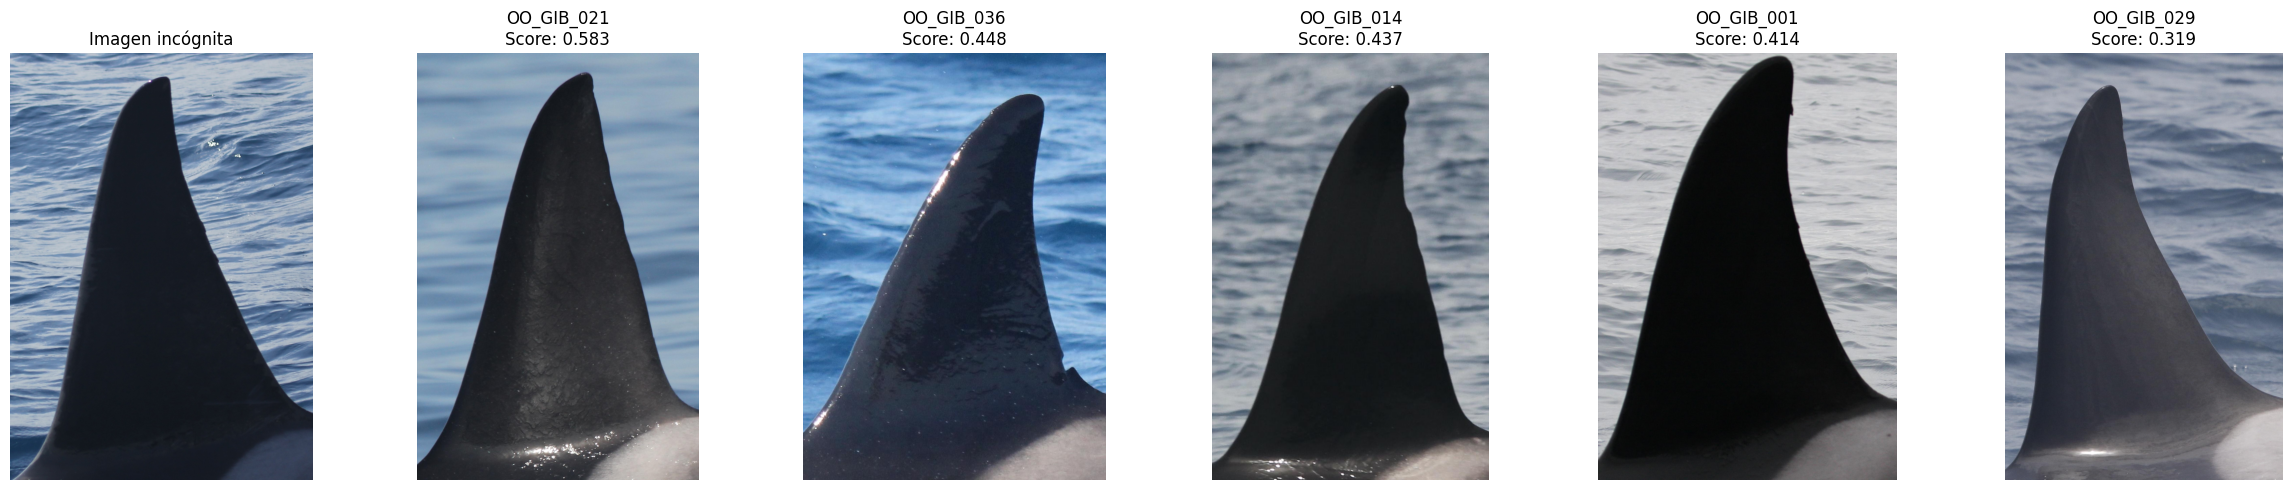

#1 → ID: OO_GIB_021 | Score: 0.583
#2 → ID: OO_GIB_036 | Score: 0.448
#3 → ID: OO_GIB_014 | Score: 0.437
#4 → ID: OO_GIB_001 | Score: 0.414
#5 → ID: OO_GIB_029 | Score: 0.319


In [ ]:
from torchvision import transforms
import torch
from PIL import Image

query_image_path = "/content/drive/MyDrive/TFM/Orca/OO_2025_3.JPG"

catalog_pkl_path = "/content/drive/MyDrive/TFM/modelos2/catalog_triplet_left_REDEF.pkl"



#USO FUNCIÓN Y VISUALIZACIÓN

top_k_resultados = find_top_k_sklearn(
    model=model,
    query_image_path=query_image_path,
    catalog_pkl_path=catalog_pkl_path,
    transform=transform,
    device=device,
    k=5,
    metric='cosine'
)

for i, (class_id, score, _) in enumerate(top_k_resultados):
    print(f"#{i+1} → ID: {class_id} | Score: {score:.3f}")


**FUNCIÓN PARA EVALUAR DESEMPEÑO MODELO CON TEST**

In [ ]:
from sklearn.neighbors import NearestNeighbors
import torch
import torch.nn.functional as F
from PIL import Image
import os
import pickle
import numpy as np

def get_embedding(model, image_path, transform, device): #función de creación de embeddings
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model(img_tensor).squeeze(0)
        embedding = F.normalize(embedding, p=2, dim=0)
    return embedding.cpu().numpy()

#definición función de cálculo de precisión

def calculate_topk_accuracy_with_knn(model, test_folder, catalog_pkl_path, transform, device, k_values=[1, 3, 5], metric='cosine'):
    model.eval()

    # Cargar catálogo
    with open(catalog_pkl_path, 'rb') as f:
        catalog = pickle.load(f)

    class_ids = list(catalog.keys())
    embeddings = np.stack([catalog[c]['embedding'].numpy() for c in class_ids])

    # Inicializar modelo KNN
    knn = NearestNeighbors(n_neighbors=max(k_values), metric=metric)
    knn.fit(embeddings)

    # Inicializar contadores
    correct_topk = {k: 0 for k in k_values}
    total = 0

    for individual in os.listdir(test_folder):
        individual_path = os.path.join(test_folder, individual)
        if not os.path.isdir(individual_path):
            continue

        image_files = [f for f in os.listdir(individual_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        for img_name in image_files:
            img_path = os.path.join(individual_path, img_name)

            # Embedding de la imagen de test
            query_emb = get_embedding(model, img_path, transform, device).reshape(1, -1)

            # Buscar vecinos
            _, indices = knn.kneighbors(query_emb)

            # Obtener predicciones
            top_preds = [class_ids[i] for i in indices[0]]

            for k in k_values:
                if individual in top_preds[:k]:
                    correct_topk[k] += 1

            total += 1

    # Calcular precisión top-k

    accuracy_topk = {k: correct_topk[k] / total if total > 0 else 0.0 for k in k_values}
    return accuracy_topk


**USO FUNCIÓN DE EVALUACIÓN MODELO PREDICCIONES CONJUNTO TEST**

In [ ]:
test_folder = '/content/drive/MyDrive/TFM/CAT_REDEF_20/right/test'
catalog_pkl = '/content/drive/MyDrive/TFM/modelos2/catalog_triplet_right512_12_aucR18_final_cos.pkl'

accuracy_topk = calculate_topk_accuracy_with_knn(
    model=model,
    test_folder=test_folder,
    catalog_pkl_path=catalog_pkl,
    transform=transform,
    device=device,
    k_values=[1, 2, 3, 4, 5],
    metric='cosine'
)

# Mostrar resultados
for k, acc in accuracy_topk.items():
    print(f"Precisión Top-{k}: {acc * 100:.2f}%")

Precisión Top-1: 45.00%
Precisión Top-2: 60.00%
Precisión Top-3: 85.00%
Precisión Top-4: 90.00%
Precisión Top-5: 100.00%


**VISUALIZAR EMBEDDINGS**

In [ ]:

import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

test_folder = "/content/drive/MyDrive/TFM/CAT_REDEF_20/right/test"

# Dataset de test
test_dataset = datasets.ImageFolder(root=test_folder, transform=val_transform)

# DataLoader
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0
)

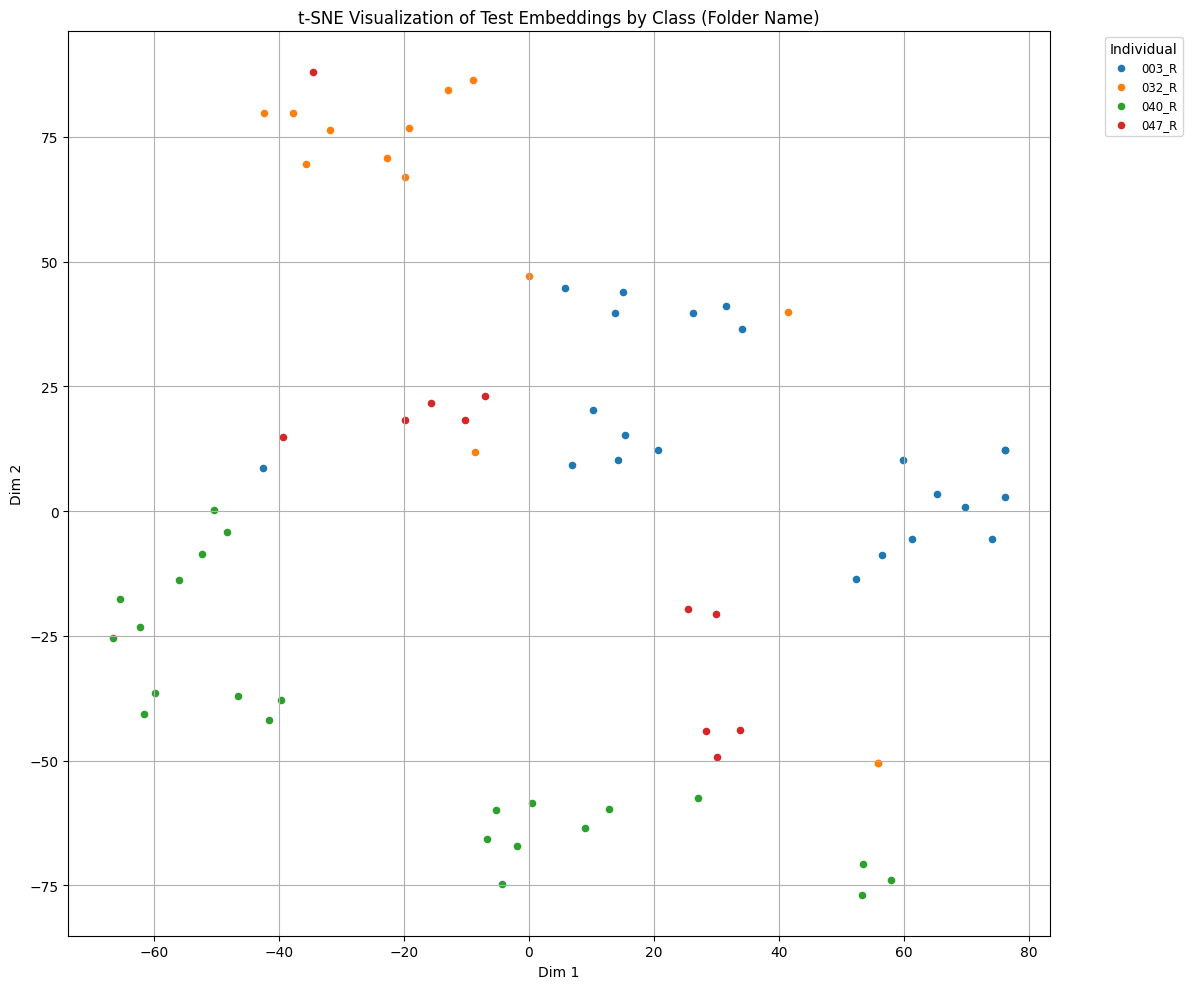

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Evaluación del modelo
model.eval()
all_embeddings = []
all_labels = []

# Obtener embeddings
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        embeddings = model(images)
        all_embeddings.append(embeddings.cpu())
        all_labels.extend(labels)

# Unir todo
all_embeddings = torch.cat(all_embeddings, dim=0).numpy()
all_labels = np.array(all_labels)

# Obtener nombres de clases desde el dataset
class_names = test_dataset.classes  # ['orca_001', 'orca_002', ...]
all_labels_encoded = all_labels     # ya están codificados como índices enteros

# Reducir a 2D con t-SNE
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
embeddings_2d = tsne.fit_transform(all_embeddings)

# Gráfico con leyenda de nombres de carpetas
plt.figure(figsize=(12, 10))

for class_idx, class_name in enumerate(class_names):
    idx = all_labels_encoded == class_idx
    plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], s=20, label=class_name)

plt.title('t-SNE Visualization of Test Embeddings by Class (Folder Name)')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.legend(title="Individual", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()



**GUARDAR SOLO LOS PESOS DE LOS MODELOS PARA REDUCIR TAMAÑO ARCHIVOS APP**

In [ ]:
import torch

# Ruta del archivo con toda la información
full_checkpoint_path = "/content/drive/MyDrive/TFM/modelos2/best_triplet_model_left_aucR18_512_final_cos.pth"
weights_only_path = "/content/drive/MyDrive/TFM/modelos2/best_triplet_left_R18_512_pesos.pth"

# Cargar el checkpoint completo
checkpoint = torch.load(full_checkpoint_path, map_location="cpu", weights_only=False)

# Extraer solo los pesos del modelo
model_weights = checkpoint['model_state_dict']

# Guardar solo los pesos
torch.save(model_weights, weights_only_path)

print(f"Pesos del modelo guardados en: {weights_only_path}")


Pesos del modelo guardados en: /content/drive/MyDrive/TFM/modelos2/best_triplet_left_R18_512_pesos.pth
